Analiza podatkov tekmovanj EGMO
===============================

Vezni tekst neki neki idk

Load data from .csv

Done ig

In [5]:
import pandas as pd

egmo_array = [pd.read_csv(f"podatki/csv/egmo{i}.csv") for i in range(2, 11)]
egmo = pd.concat(egmo_array, keys=[f"EGMO {i}" for i in range(2, 11)])
egmo[(egmo["code"].str.contains("SVN")) & (egmo["prize"] > 0)].sort_values(["prize", "name"], ascending=[False, True])

code              name  P1  P2  P3  P4  P5  P6  prize
EGMO 8  173  SVN2       Tea Jeličić   7   7   0   7   1   0      3
EGMO 6  144  SVN1  Ana Meta Dolinar   7   0   0   7   0   0      2
EGMO 7  171  SVN1  Ana Meta Dolinar   6   1   1   7   0   0      2
EGMO 8  172  SVN1  Ana Meta Dolinar   7   4   0   7   1   0      2
        174  SVN3        Ema Mlinar   7   0   0   7   3   1      2
EGMO 10 188  SVN1    Katarina Grilj   0   0   0   7   3   0      2
EGMO 3  87   SVN2       Lara Jerman   0   1   0   0   7   0      2
EGMO 2  65   SVN3   Maruša Pečovnik   7   3   0   6   0   0      2
EGMO 7  173  SVN3        Ana Opalič   7   0   1   2   0   0      1
EGMO 6  145  SVN2    Klara Drofenik   7   0   0   0   2   0      1
EGMO 4  89   SVN3       Klara Nosan   1   2   0   7   0   0      1
EGMO 2  63   SVN1       Lara Jerman   7   4   0   2   0   0      1
        66   SVN4    Mihaela Pušnik   7   2   0   2   2   0      1
EGMO 4  90   SVN4    Timeja Strašek   7   0   0   0   0   0      1
EGMO 7  174  SVN4       Špela Polak   7   1   0   2   0   0      1
EGMO 8  175  SVN4       Špela Polak   4   0   0   7   1   0      1

Do some analysis

<AxesSubplot:>

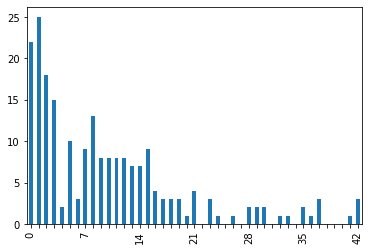

In [6]:
egmo10 = pd.read_csv("podatki/csv/egmo10.csv")
egmo10['skupaj'] = sum(egmo10[f"P{i}"] for i in range(1,7))
graf = egmo10['skupaj'].value_counts().reindex(index=[t for t in range(43)]).sort_index().plot.bar(x='skupaj', y='count')
for i, t in enumerate(graf.get_xticklabels()):
    if (i % 7) != 0:
        t.set_visible(False)
graf

Predictor al neki idk

<AxesSubplot:xlabel='idx'>

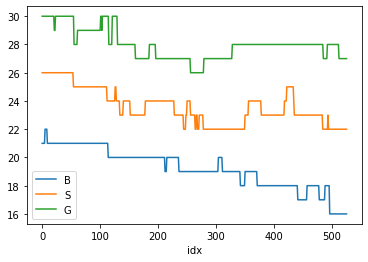

In [7]:
import predictor

predictor.main().plot.line()

<AxesSubplot:xlabel='idx'>

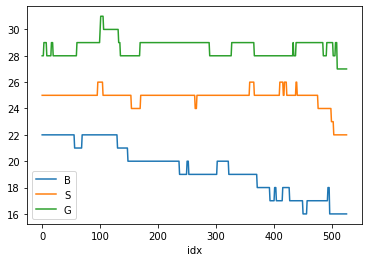

In [8]:
predictor.main(fq=True).plot.line()